# Qubit compilation of photonic circuits.

We show how to map qubit circuits to post-selected linear optical circuits via the ZX calculus.

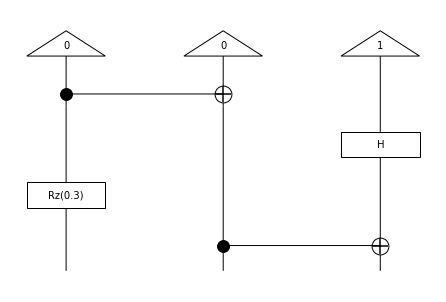

In [1]:
from discopy.quantum import CX, H, Id, Rz, Rx, CZ, Ket, Bra

circuit = Ket(0, 0, 1) >> CX @ H >> Rz(0.3) @ CX
circuit.draw()

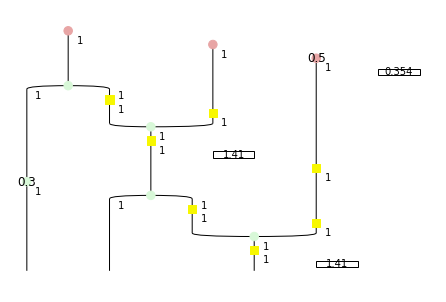

In [2]:
from discopy.quantum.zx import circuit2zx, decomp

diagram = decomp(circuit2zx(circuit))
diagram.draw()

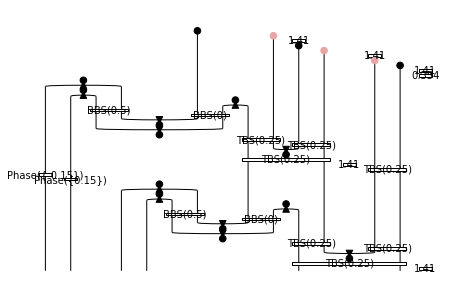

In [3]:
from discopy.quantum.optics import zx2path

circ = zx2path(diagram)
circ.draw(draw_type_labels=False)

In [4]:
def dual_rail_states(n_qubits):
    strings = []
    def genbin(n, bs=[]):
        if len(bs) == 2*n:
            strings.append(bs)
        else:
            genbin(n, bs + [1, 0])
            genbin(n, bs + [0, 1])
    genbin(n_qubits)
    return strings

dual_rail_states(2)

[[1, 0, 1, 0], [1, 0, 0, 1], [0, 1, 1, 0], [0, 1, 0, 1]]

Compute amplitudes of the post-selected photonic circuit

In [5]:
from discopy.quantum.optics import evaluate, qpath_drag, to_matrix
import numpy as np

states = dual_rail_states(len(circuit.cod))
array = np.array([evaluate(circ, [], y) for y in states])

Check that the compiled photonic circuit has the same semantics as the qubit circuit we started with, up to a scalar.

In [6]:
assert np.allclose(array.flatten(), circuit.eval().array.flatten())

Extract unitary photonic circuit and get metrics

In [7]:
from discopy.quantum.optics import qpath_drag, make_square, Id, annil, create

bot, top, mid, scalar = qpath_drag(make_square(circ))
n_modes, n_photons = len(mid.dom), bot.boxes.count(create)
print('Number of modes: {}'.format(n_modes))
print('Number of input photons: {}'.format(n_photons))
print('Number of post-selected photons: {}'.format(top.boxes.count(annil)))
print('Normalisation scalar: {:.3f}'.format(scalar))

Number of modes: 18
Number of input photons: 9
Number of post-selected photons: 6
Normalisation scalar: 2.000


In [8]:
assert np.allclose((mid >> mid.dagger()).array, Id(len(mid.dom)).array)

In [9]:
from discopy.quantum.optics import occupation_numbers, annil, counit

def list2effect(x):
    return Id(0).tensor(*[annil if a == 1 else counit for a in x])

input_state = [1 if box == create else 0 for box in bot.normal_form().boxes]
n_qubits = bot.boxes.count(create) - top.boxes.count(annil)
effects = [top >> list2effect(eff) for eff in dual_rail_states(n_qubits)]
accept_states = [[1 if box == annil else 0 for box in effect.normal_form().boxes] for effect in effects]

In [10]:
p_success = sum([mid.indist_prob(input_state, state) for state in accept_states])
print('Probability of success = {}'.format(p_success))

Probability of success = 6.103515625000003e-05


In [12]:
# import perceval as pcvl
# import perceval.lib.symb as symb
# simulator = pcvl.BackendFactory().get_backend("SLOS")
# x = simulator(pcvl.Matrix(mid.array)).evolve(pcvl.BasicState(input_state))